In [5]:
import cv2, numpy as np
import sys, os
import matplotlib.pyplot as plt
import copy
from PIL import Image

def get_new(old):
    new = np.ones(old.shape, np.uint8)
    cv2.bitwise_not(new,new)
    return new

# these constants are carefully picked
MORPH = 9
CANNY = 84
HOUGH = 25

In [6]:
def process_image (original_img):

    orig = copy.copy(original_img)
    # orig = cv2.imread(sys.argv[1])

    img = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
    cv2.GaussianBlur(img, (3,3), 0, img)

    # Task : Learn about bilateral filters

    # img = cv2.bilateralFilter (img, 3, 30, 70)
    img = cv2.medianBlur (img, 5)
    # cv2.GaussianBlur(img, (3,3), 0, img)

    # this is to recognize white on white
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(MORPH,MORPH))
    dilated = cv2.dilate(img, kernel)

    edges = cv2.Canny(dilated, 0, CANNY, apertureSize=3)

    lines = cv2.HoughLinesP(edges, 1,  3.14/180, HOUGH)
    for line in lines[0]:
            cv2.line(edges, (line[0], line[1]), (line[2], line[3]),
                            (255,0,0), 2, 8)

    # finding contours
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL,
                                    cv2.CHAIN_APPROX_TC89_KCOS)
    contours = filter(lambda cont: cv2.arcLength(cont, False) > 100, contours)
    contours = filter(lambda cont: cv2.contourArea(cont) > 10000, contours)

    # simplify contours down to polygons
    rects = []
    for cont in contours:
        rect = cv2.approxPolyDP(cont, 40, True).copy().reshape(-1, 2)
        rects.append(rect)

    # that's basically it
    cv2.drawContours(orig, rects,-1,(0,255,0),1)

    # show only contours
    new = get_new(img)
    cv2.drawContours(new, rects,-1,(0,255,0),1)
    cv2.GaussianBlur(new, (9,9), 0, new)
    new = cv2.Canny(new, 0, CANNY, apertureSize=3)
    dilated = cv2.cvtColor(dilated, cv2.COLOR_GRAY2RGB)
    edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

    return orig, dilated, edges


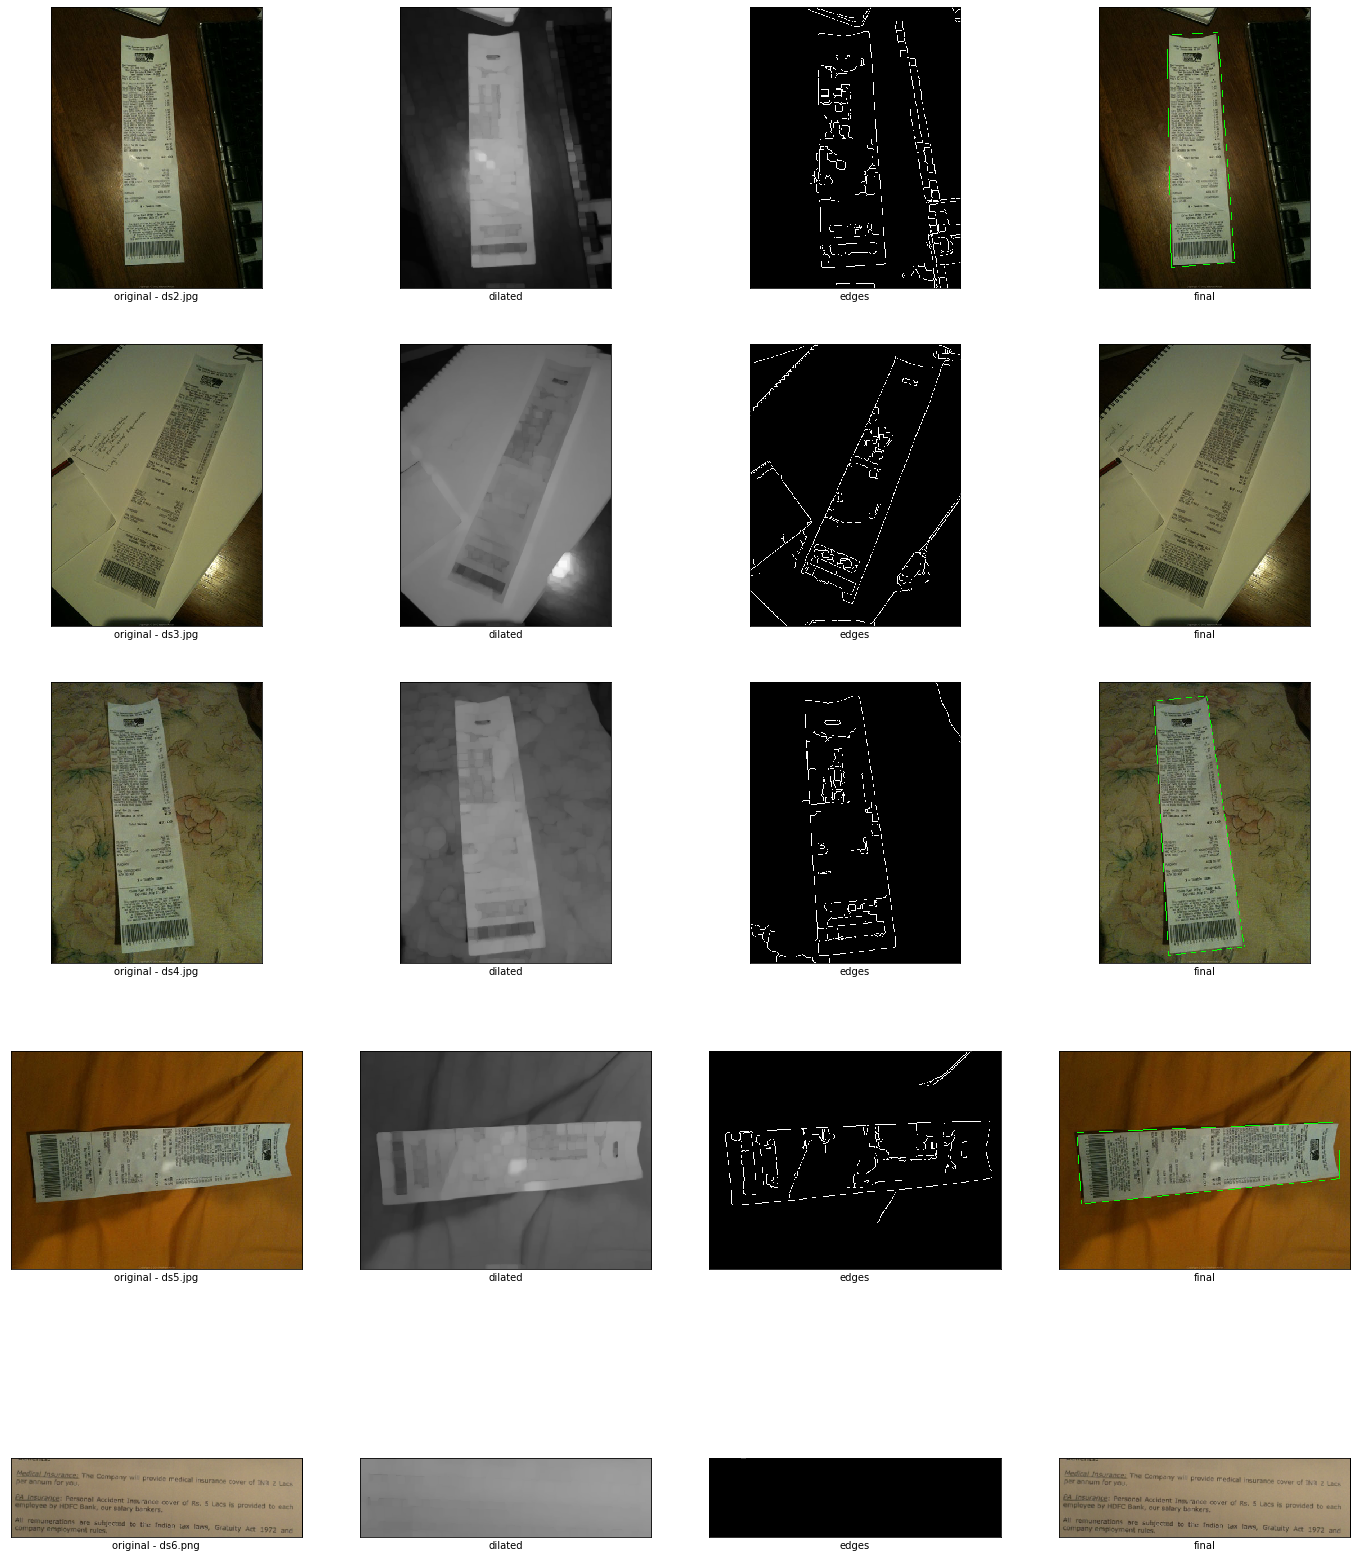

In [7]:
img_names = os.listdir('../../data/')
img_names.sort()
total_images = len(img_names)
plt.figure(figsize=(24, total_images * 6))

def plot_image (id, label, img):
    plt.subplot (total_images, 4, id)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img)
    plt.xlabel(label)

for i, img_name in enumerate(img_names):
    original_img = np.array(Image.open('../../data/' + img_name))
    orig, dilated, edges = process_image (original_img)
    plot_image (4 * i + 1, 'original - ' + img_name, original_img)
    plot_image (4 * i + 2, 'dilated', dilated)
    plot_image (4 * i + 3, 'edges', edges)
    plot_image (4 * i + 4, 'final', orig)


plt.show()
